# Importing Libraries

In [1]:
# For Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import plotly.express as px
from imblearn.over_sampling import SMOTE, RandomOverSampler
import torch
import torch.nn as nn
import torchbnn as bnn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from icd9cms import search

# Import ML Model Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# For Model Evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc 
from matplotlib import pyplot

# Importing data

In [2]:
colectomy_cci_var = pd.read_csv('./colectomy_cci_var.csv', dtype = 'str')

# Formating datatype

In [3]:
# Set random seed
np.random.seed(42)

# Obtain ICD9 codes for the parent code
def get_parent_code(code):
    if search(code) is None:
        return 'uknown'
    else:
        return search(code).parent.code

# Rename columns
colectomy_cci_var['ptsex'] = colectomy_cci_var['ptsex'].replace({'F': 'female', 'M': 'male'})
colectomy_cci_var['adtype'] = colectomy_cci_var['adtype'].replace({'1': 'emergency', '2': 'urgent', '3': 'elective'})
colectomy_cci_var['adsource'] = colectomy_cci_var['adsource'].replace({'1': 'non_healthcare_facility', '2': 'clinical_referral', '4': 'hospital_transfer', '5': 'snf_icf_transfer', '6': 'healthcare_facility_tranfer', '7': 'emergency_room', '8': 'court_law_enforcement', 'D': 'hospital_unit_transfer', 'E': 'ambulatory_surgery_center'})

# Reformat the 'age' variable typing
colectomy_cci_var['age'] = colectomy_cci_var['age'].astype(int)

# Drop observations
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != '9']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'emergency_room']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'court_law_enforcement']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'hospital_unit_transfer']

# Cluster 'pdx' codes by the ICD9 parent code
colectomy_cci_var['pdx'] = colectomy_cci_var['pdx'].apply(get_parent_code)

# Remove classes with fewer observations
colectomy_cci_var = colectomy_cci_var.groupby('pdx').filter(lambda x: len(x) >= 1000)

# Select Relevant Features
features = ['year', 'ptsex', 'race', 'adtype', 'adsource', 'admdx']
dummy_features = ['year', 'ptsex', 'race', 'adtype', 'adsource']
frequency_features = ['admdx']

# Data Preprocessing
num_secondary_admissions = 3

for i in range(1, num_secondary_admissions + 1):
    sdx = f'sdx{i}'

    features.append(sdx)
    frequency_features.append(sdx)
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].fillna('unknown')

# Split the features and label
colectomy_cci_var_X = colectomy_cci_var[features]
colectomy_cci_var_y = colectomy_cci_var['pdx']

# One-Hot Encoding
colectomy_cci_var_X = pd.get_dummies(colectomy_cci_var_X, columns = features, dtype = 'int')

# Split Data
#train_X, test_X, train_y, test_y = train_test_split(colectomy_cci_var_X, colectomy_cci_var_y, test_size = 0.2, random_state = 0)
train_X, temp_X, train_y, temp_y = train_test_split(colectomy_cci_var_X, colectomy_cci_var_y, test_size = 0.3, random_state = 0)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size = 0.5, random_state = 0)

# Data Resampling
smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
train_X, train_y = smote.fit_resample(train_X, train_y)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y)
train_y = label_encoder.transform(train_y)
val_y = label_encoder.transform(val_y)
test_y = label_encoder.transform(test_y)

X_train = train_X
X_val = val_X
X_test = test_X
Y_train = train_y
Y_val = val_y
Y_test = test_y

In [4]:
# Extracting categorical and numerical columns
cat_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype == 'object']
num_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype != 'object']

2024-11-17 22:15:45,854: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-17 22:15:45,868: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_78104/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_78104/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_78104/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.cou

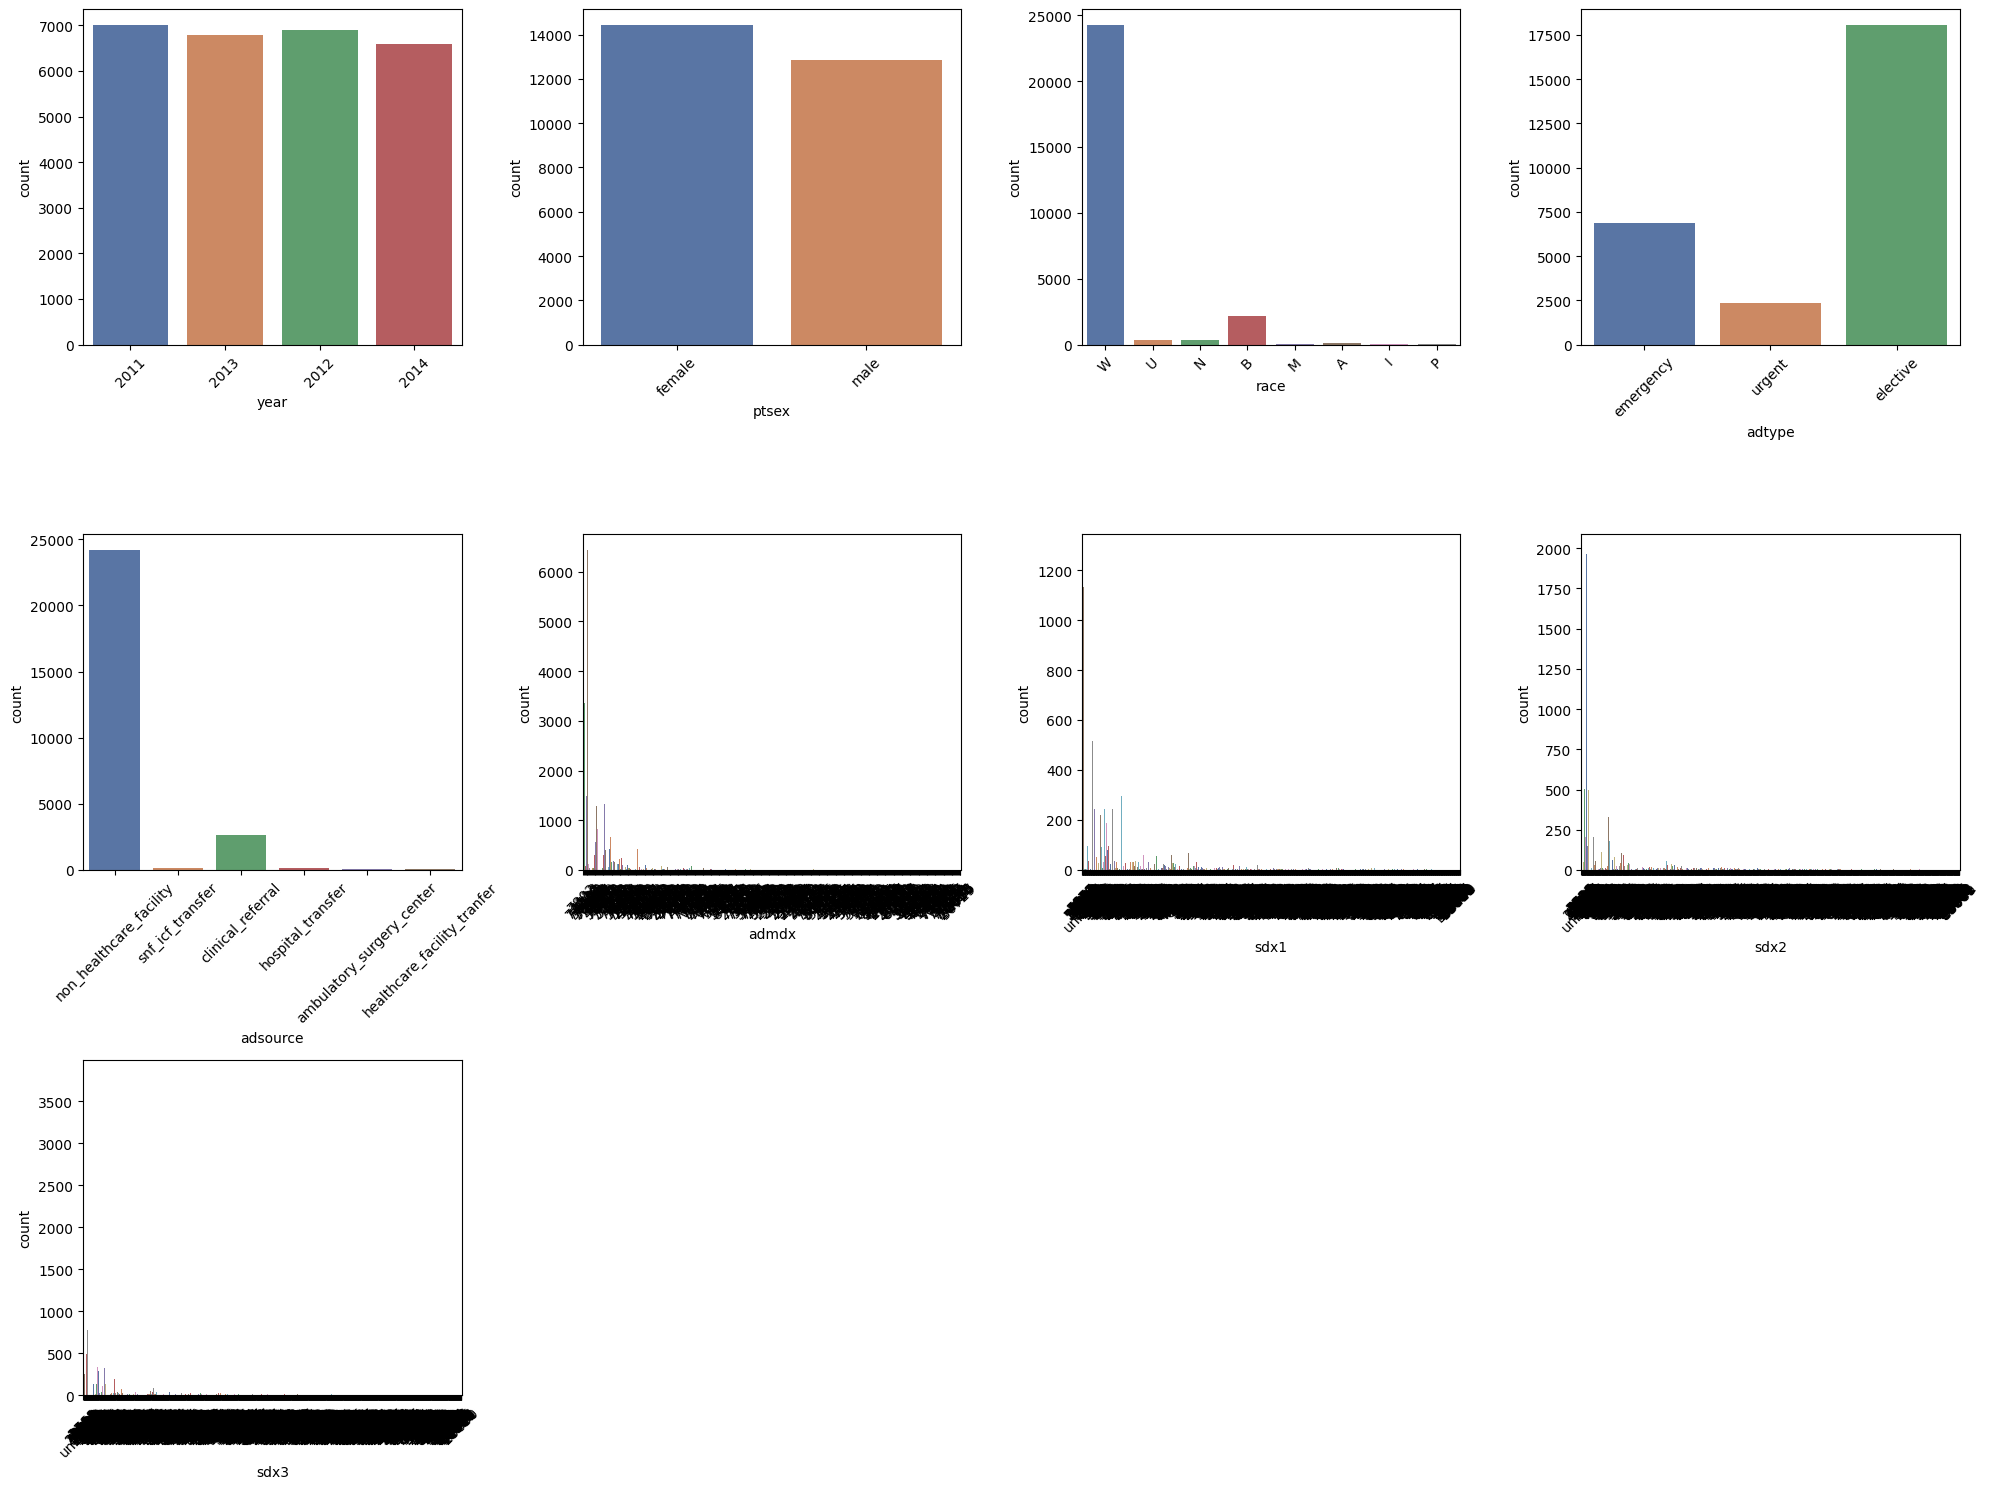

In [5]:
# looking at categorical columns

plt.figure(figsize = (20, 15))
plotnumber = 1
for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
        plt.xlabel(column)
        plt.xticks(rotation = 45)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [6]:
# Split the training set into patients below the age of 60
colectomy_cci_var_public = colectomy_cci_var[colectomy_cci_var['age'] < 60]
# Split the testing set into patients above the age of 60
colectomy_cci_var_private_other = colectomy_cci_var[colectomy_cci_var['age'] >= 60]

print(f"Length of training set: {len(colectomy_cci_var_public)}")
print(f"Length of testing set: {len(colectomy_cci_var_private_other)}")

# Split the data into the in-distribution and out-of-distribution scenarios
train_X_OOD = colectomy_cci_var_public[features]
train_y_OOD = colectomy_cci_var_public['pdx'] 
test_X_OOD = colectomy_cci_var_private_other[features]
test_y_OOD = colectomy_cci_var_private_other['pdx']

val_X_OOD, test_X_OOD, val_y_OOD, test_y_OOD = train_test_split(test_X_OOD, test_y_OOD, test_size = 0.5, random_state = 0)

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
train_X_OOD_data = encoder.fit_transform(train_X_OOD[features])
val_X_OOD_data = encoder.transform(val_X_OOD[features])
test_X_OOD_data = encoder.transform(test_X_OOD[features])

train_X_OOD = pd.DataFrame(train_X_OOD_data, columns = encoder.get_feature_names_out(features))
val_X_OOD = pd.DataFrame(val_X_OOD_data, columns = encoder.get_feature_names_out(features))
test_X_OOD = pd.DataFrame(test_X_OOD_data, columns = encoder.get_feature_names_out(features))


# Data Resampling
smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
train_X_OOD, train_y_OOD = smote.fit_resample(train_X_OOD, train_y_OOD)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y_OOD)
train_y_OOD = label_encoder.transform(train_y_OOD)
val_y_OOD = label_encoder.transform(val_y_OOD)
test_y_OOD = label_encoder.transform(test_y_OOD)


X_train_OOD = train_X_OOD
X_val_OOD = val_X_OOD
X_test_OOD = test_X_OOD
Y_train_OOD = train_y_OOD
Y_val_OOD = val_y_OOD
Y_test_OOD = test_y_OOD

Length of training set: 10348
Length of testing set: 16932


# Training In-Distribution Models

In [7]:
# Random Forest
clf_rand_forest = RandomForestClassifier()
clf_rand_forest.fit(X_train, Y_train)

# SVM
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(X_train, Y_train)

# Naive Bayes
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, Y_train)

# Logistic Regression
clf_log = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log.fit(X_train, Y_train)

# KNN
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train, Y_train)

# XG Boost
clf_xgb = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb.fit(X_train, Y_train)

# Decision Tree
clf_dtc = DecisionTreeClassifier()
clf_dtc.fit(X_train, Y_train)

# Ada Boost
clf_ada = AdaBoostClassifier(estimator = clf_dtc)
clf_ada.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

In [8]:
# Model Architecture
class BayesianNeuralNetwork(nn.Module):
    def __init__(self, feature_size, num_classes, layer_1_size, layer_2_size, layer_3_size):
        super().__init__()
        prior_mean = 0
        prior_variance = 1

        # Layers
        self.bayes_linear_1 = bnn.BayesLinear(prior_mu = prior_mean, prior_sigma = prior_variance, in_features = feature_size, out_features = layer_1_size)
        self.bayes_linear_2 = bnn.BayesLinear(prior_mu = prior_mean, prior_sigma = prior_variance, in_features = layer_1_size, out_features = layer_2_size)
        self.bayes_linear_3 = bnn.BayesLinear(prior_mu = prior_mean, prior_sigma = prior_variance, in_features = layer_2_size, out_features = layer_3_size)

        self.output_layer = nn.Linear(in_features = layer_3_size, out_features = num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bayes_linear_1(x))
        x = torch.relu(self.bayes_linear_2(x))
        x = torch.relu(self.bayes_linear_3(x))

        logits = self.output_layer(x)
        #probabilities = torch.softmax(logits, dim=-1)
        return logits
    
    def predict(self, x, num_samples = 1000):
        self.eval()
        outputs = []

        with torch.no_grad():
            for i in range(num_samples):
                output_sample = self(x)
                outputs.append(output_sample)

        # Class prediction
        outputs = torch.stack(outputs).numpy()
        mean_output = np.mean(outputs, axis = 0)
        predicted_classes = np.argmax(mean_output, axis = 1)

        # Uncertainty Estimation
        epistemic_uncertainty = np.var(outputs, axis = 0)
        mean_epistemic_uncertainty = np.mean(epistemic_uncertainty)

        return predicted_classes, mean_epistemic_uncertainty
    

# Loss Function
def elbo_loss(output, target, model, lam):
    standard_loss = nn.CrossEntropyLoss()(output, target)
    # The BKLLoss function automatically predfines the variational distribution as a normal distribution
    kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)

    return standard_loss + (kl_loss(model) * lam)

def train(model, train_loader, val_loader, optimizer, scheduler, epochs = 5):
    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = None
    lam_weight = 10

    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = elbo_loss(output, target, model, lam_weight)
            loss.backward()
            optimizer.step()

        scheduler.step()    
        print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}")
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += elbo_loss(output, target, model, lam_weight).item()

        val_loss = (val_loss / len(val_loader))

        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    print(f"Best Epoch: {best_epoch}")
    print(f"Best Validation Loss: {best_val_loss}")
    return best_model_state


# Reformat the training set
X_train_tensor = torch.tensor(X_train.values).float()
Y_train_tensor = torch.tensor(pd.Series(Y_train).values).long()

dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Reformat the validation set
X_val_tensor = torch.tensor(X_val.values).float()
Y_val_tensor = torch.tensor(pd.Series(Y_val).values).long()

dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(dataset, batch_size = 32, shuffle = True)

model = BayesianNeuralNetwork(feature_size = X_train.shape[1], num_classes = len(torch.unique(Y_train_tensor)), layer_1_size = 128, layer_2_size = 128, layer_3_size = 128)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = StepLR(optimizer, step_size = 2, gamma = 0.5)
best_model_state = train(model, train_loader, val_loader, optimizer, scheduler, 20)

Epoch 1, Training Loss: 2.5595412254333496
Epoch 2, Training Loss: 2.0905513763427734
Epoch 3, Training Loss: 2.0685131549835205
Epoch 4, Training Loss: 1.9110660552978516
Epoch 5, Training Loss: 1.568655252456665
Epoch 6, Training Loss: 1.731858491897583
Epoch 7, Training Loss: 1.5353074073791504
Epoch 8, Training Loss: 1.5691031217575073
Epoch 9, Training Loss: 1.6503833532333374
Epoch 10, Training Loss: 1.5399116277694702
Epoch 11, Training Loss: 1.6285192966461182
Epoch 12, Training Loss: 1.590820074081421
Epoch 13, Training Loss: 1.6130642890930176
Epoch 14, Training Loss: 1.5555856227874756
Epoch 15, Training Loss: 1.5977749824523926
Epoch 16, Training Loss: 1.5586504936218262
Epoch 17, Training Loss: 1.6061902046203613
Epoch 18, Training Loss: 1.5482792854309082
Epoch 19, Training Loss: 1.5811398029327393
Epoch 20, Training Loss: 1.5518484115600586
Best Epoch: 11
Best Validation Loss: 1.5272201914340258


In [9]:
X_test_tensor = torch.tensor(X_test.values).float()

model.load_state_dict(best_model_state)
model.eval()

predicted_classes, epistemic_uncertainty = model.predict(X_test_tensor, num_samples = 2500)

bnn_acc = accuracy_score(Y_test, predicted_classes)

print(f"Accuracy: {bnn_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, predicted_classes)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, predicted_classes)}")
print(f"Epistemic Uncertainty: {epistemic_uncertainty}")
print(f"Classification Report: \n{classification_report(Y_test, predicted_classes, zero_division = 1)}")

Accuracy: 0.40298142717497554
Mean Absolute Error: 1.83822091886608
Mean Squared Error: 6.613880742913001
Epistemic Uncertainty: 118.328857421875
Classification Report: 
              precision    recall  f1-score   support

           0       0.40      1.00      0.57      1649
           1       1.00      0.00      0.00       558
           2       1.00      0.00      0.00       189
           3       1.00      0.00      0.00       198
           4       1.00      0.00      0.00      1498

    accuracy                           0.40      4092
   macro avg       0.88      0.20      0.11      4092
weighted avg       0.76      0.40      0.23      4092



# Training OOD Models

In [10]:
# Random Forest
clf_rand_forest_OOD = RandomForestClassifier()
clf_rand_forest_OOD.fit(X_train_OOD, Y_train_OOD)

# SVM
clf_svm_OOD = svm.SVC(kernel = 'linear')
clf_svm_OOD.fit(X_train_OOD, Y_train_OOD)

# Naive Bayes
clf_gnb_OOD = GaussianNB()
clf_gnb_OOD.fit(X_train_OOD, Y_train_OOD)

# Logistic Regression
clf_log_OOD = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log_OOD.fit(X_train_OOD, Y_train_OOD)

# KNN
clf_knn_OOD = KNeighborsClassifier(n_neighbors = 5)
clf_knn_OOD.fit(X_train_OOD, Y_train_OOD)

# XG Boost
clf_xgb_OOD = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb_OOD.fit(X_train_OOD, Y_train_OOD)

# Decision Tree
clf_dtc_OOD = DecisionTreeClassifier()
clf_dtc_OOD.fit(X_train_OOD, Y_train_OOD)

# Ada Boost
clf_ada_OOD = AdaBoostClassifier(estimator = clf_dtc_OOD)
clf_ada_OOD.fit(X_train_OOD, Y_train_OOD)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

In [11]:
# Model Architecture
class BayesianNeuralNetwork(nn.Module):
    def __init__(self, feature_size, num_classes, layer_1_size, layer_2_size, layer_3_size):
        super().__init__()
        prior_mean = 0
        prior_variance = 1

        # Layers
        self.bayes_linear_1 = bnn.BayesLinear(prior_mu = prior_mean, prior_sigma = prior_variance, in_features = feature_size, out_features = layer_1_size)
        self.bayes_linear_2 = bnn.BayesLinear(prior_mu = prior_mean, prior_sigma = prior_variance, in_features = layer_1_size, out_features = layer_2_size)
        self.bayes_linear_3 = bnn.BayesLinear(prior_mu = prior_mean, prior_sigma = prior_variance, in_features = layer_2_size, out_features = layer_3_size)

        self.output_layer = nn.Linear(in_features = layer_3_size, out_features = num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bayes_linear_1(x))
        x = torch.relu(self.bayes_linear_2(x))
        x = torch.relu(self.bayes_linear_3(x))

        logits = self.output_layer(x)
        #probabilities = torch.softmax(logits, dim=-1)
        return logits
    
    def predict(self, x, num_samples = 1000):
        self.eval()
        outputs = []

        with torch.no_grad():
            for i in range(num_samples):
                output_sample = self(x)
                outputs.append(output_sample)

        # Class prediction
        outputs = torch.stack(outputs).numpy()
        mean_output = np.mean(outputs, axis = 0)
        predicted_classes = np.argmax(mean_output, axis = 1)

        # Uncertainty Estimation
        epistemic_uncertainty = np.var(outputs, axis = 0)
        mean_epistemic_uncertainty = np.mean(epistemic_uncertainty)

        return predicted_classes, mean_epistemic_uncertainty
    

# Loss Function
def elbo_loss(output, target, model, lam):
    standard_loss = nn.CrossEntropyLoss()(output, target)
    # The BKLLoss function automatically predfines the variational distribution as a normal distribution
    kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)

    return standard_loss + (kl_loss(model) * lam)

def train(model, train_loader, val_loader, optimizer, scheduler, epochs = 5):
    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = None
    lam_weight = 10

    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = elbo_loss(output, target, model, lam_weight)
            loss.backward()
            optimizer.step()

        scheduler.step()    
        print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}")
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += elbo_loss(output, target, model, lam_weight).item()

        val_loss = (val_loss / len(val_loader))

        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    print(f"Best Epoch: {best_epoch}")
    print(f"Best Validation Loss: {best_val_loss}")
    return best_model_state


# Reformat the training set
X_train_tensor_OOD = torch.tensor(X_train_OOD.values).float()
Y_train_tensor_OOD = torch.tensor(pd.Series(Y_train_OOD).values).long()

dataset = TensorDataset(X_train_tensor_OOD, Y_train_tensor_OOD)
train_loader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Reformat the validation set
X_val_tensor_OOD = torch.tensor(X_val_OOD.values).float()
Y_val_tensor_OOD = torch.tensor(pd.Series(Y_val_OOD).values).long()

dataset = TensorDataset(X_val_tensor_OOD, Y_val_tensor_OOD)
val_loader = DataLoader(dataset, batch_size = 32, shuffle = True)

model = BayesianNeuralNetwork(feature_size = X_train_OOD.shape[1], num_classes = len(torch.unique(Y_train_tensor_OOD)), layer_1_size = 128, layer_2_size = 128, layer_3_size = 128)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = StepLR(optimizer, step_size = 2, gamma = 0.5)
best_model_state = train(model, train_loader, val_loader, optimizer, scheduler, 20)

Epoch 1, Training Loss: 2.5352261066436768
Epoch 2, Training Loss: 1.269450068473816
Epoch 3, Training Loss: 2.3252766132354736
Epoch 4, Training Loss: 2.7525482177734375
Epoch 5, Training Loss: 1.869944453239441
Epoch 6, Training Loss: 1.8446389436721802
Epoch 7, Training Loss: 1.7289018630981445
Epoch 8, Training Loss: 1.6911678314208984
Epoch 9, Training Loss: 1.794317603111267
Epoch 10, Training Loss: 1.6894065141677856
Epoch 11, Training Loss: 1.6262774467468262
Epoch 12, Training Loss: 1.6743566989898682
Epoch 13, Training Loss: 1.5683374404907227
Epoch 14, Training Loss: 1.5280498266220093
Epoch 15, Training Loss: 1.562681794166565
Epoch 16, Training Loss: 1.6386810541152954
Epoch 17, Training Loss: 1.595497488975525
Epoch 18, Training Loss: 1.6488289833068848
Epoch 19, Training Loss: 1.6455090045928955
Epoch 20, Training Loss: 1.6085326671600342
Best Epoch: 10
Best Validation Loss: 1.5635816740539838


In [12]:
X_test_tensor_OOD = torch.tensor(X_test_OOD.values).float()

model.load_state_dict(best_model_state)
model.eval()

predicted_classes, epistemic_uncertainty = model.predict(X_test_tensor_OOD, num_samples = 2500)

bnn_acc_OOD = accuracy_score(Y_test_OOD, predicted_classes)

print(f"Accuracy: {bnn_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, predicted_classes)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, predicted_classes)}")
print(f"Epistemic Uncertainty: {epistemic_uncertainty}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, predicted_classes, zero_division = 1)}")

Accuracy: 0.2758091188282542
Mean Absolute Error: 2.29884242853768
Mean Squared Error: 8.252539570044885
Epistemic Uncertainty: 200.26036071777344
Classification Report: 
              precision    recall  f1-score   support

           0       0.43      0.07      0.12      4252
           1       0.18      0.17      0.17      1356
           2       1.00      0.00      0.00        84
           3       1.00      0.00      0.00       444
           4       0.28      0.78      0.41      2330

    accuracy                           0.28      8466
   macro avg       0.58      0.20      0.14      8466
weighted avg       0.38      0.28      0.20      8466



# Evaluation

### Random Forest

In-Distribution

In [13]:
Y_pred = clf_rand_forest.predict(X_test)

rand_forest_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {rand_forest_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8382209188660802
Mean Absolute Error: 0.3326001955034213
Mean Squared Error: 0.8829423264907136
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1649
           1       0.73      0.89      0.80       558
           2       0.59      0.83      0.69       189
           3       0.46      0.79      0.58       198
           4       0.94      0.89      0.91      1498

    accuracy                           0.84      4092
   macro avg       0.73      0.84      0.77      4092
weighted avg       0.87      0.84      0.85      4092



Out-of-Distribution

In [14]:
Y_pred = clf_rand_forest_OOD.predict(X_test_OOD)

rand_forest_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {rand_forest_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8401842664776754
Mean Absolute Error: 0.38282541932435626
Mean Squared Error: 1.1999763760926057
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      4252
           1       0.83      0.83      0.83      1356
           2       0.39      0.77      0.52        84
           3       0.68      0.56      0.61       444
           4       0.82      0.88      0.85      2330

    accuracy                           0.84      8466
   macro avg       0.72      0.78      0.74      8466
weighted avg       0.84      0.84      0.84      8466



### SVM

In-Distribution

In [15]:
Y_pred = clf_svm.predict(X_test)

svm_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {svm_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8682795698924731
Mean Absolute Error: 0.29765395894428154
Mean Squared Error: 0.8724340175953079
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1649
           1       0.80      0.86      0.83       558
           2       0.72      0.80      0.76       189
           3       0.63      0.71      0.67       198
           4       0.94      0.90      0.92      1498

    accuracy                           0.87      4092
   macro avg       0.80      0.83      0.81      4092
weighted avg       0.87      0.87      0.87      4092



Out-of-Distribution

In [16]:
Y_pred = clf_svm_OOD.predict(X_test_OOD)

svm_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {svm_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8264824001889912
Mean Absolute Error: 0.38837703756201275
Mean Squared Error: 1.1311126860382708
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      4252
           1       0.75      0.86      0.80      1356
           2       0.22      0.71      0.34        84
           3       0.59      0.67      0.63       444
           4       0.89      0.82      0.85      2330

    accuracy                           0.83      8466
   macro avg       0.67      0.78      0.70      8466
weighted avg       0.85      0.83      0.83      8466



### Naive Bayes

In-Distribution

In [17]:
Y_pred = clf_gnb.predict(X_test)

gnb_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {gnb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.34628543499511244
Mean Absolute Error: 0.9958455522971652
Mean Squared Error: 2.0559628543499513
Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.25      0.38      1649
           1       0.25      0.58      0.34       558
           2       0.24      0.71      0.36       189
           3       0.10      0.53      0.17       198
           4       0.73      0.29      0.42      1498

    accuracy                           0.35      4092
   macro avg       0.41      0.47      0.33      4092
weighted avg       0.62      0.35      0.38      4092



Out-of-Distribution

In [18]:
Y_pred = clf_gnb_OOD.predict(X_test_OOD)

gnb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {gnb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.40881171745806755
Mean Absolute Error: 1.1068981809591307
Mean Squared Error: 2.818686510748878
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.44      0.54      4252
           1       0.31      0.68      0.43      1356
           2       0.07      0.48      0.12        84
           3       0.15      0.52      0.23       444
           4       0.51      0.18      0.26      2330

    accuracy                           0.41      8466
   macro avg       0.35      0.46      0.32      8466
weighted avg       0.55      0.41      0.43      8466



### Logistic Regression

In-Distribution

In [19]:
Y_pred = clf_log.predict(X_test)

log_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {log_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8724340175953079
Mean Absolute Error: 0.2812805474095797
Mean Squared Error: 0.8081622678396871
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1649
           1       0.81      0.87      0.84       558
           2       0.74      0.83      0.78       189
           3       0.60      0.76      0.67       198
           4       0.94      0.91      0.92      1498

    accuracy                           0.87      4092
   macro avg       0.80      0.84      0.82      4092
weighted avg       0.88      0.87      0.87      4092



Out-of-Distribution

In [20]:
Y_pred = clf_log_OOD.predict(X_test_OOD)

log_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {log_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8365225608315615
Mean Absolute Error: 0.3629813371131585
Mean Squared Error: 1.048074651547366
Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4252
           1       0.78      0.88      0.83      1356
           2       0.24      0.76      0.37        84
           3       0.55      0.79      0.65       444
           4       0.91      0.82      0.86      2330

    accuracy                           0.84      8466
   macro avg       0.68      0.82      0.71      8466
weighted avg       0.86      0.84      0.84      8466



### KNN

In-Distribution

In [21]:
Y_pred = clf_knn.predict(X_test)

knn_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {knn_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.4227761485826002
Mean Absolute Error: 1.088954056695992
Mean Squared Error: 2.4731182795698925
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.05      0.10      1649
           1       0.40      0.90      0.56       558
           2       0.17      0.74      0.28       189
           3       0.15      0.83      0.26       198
           4       0.98      0.56      0.71      1498

    accuracy                           0.42      4092
   macro avg       0.53      0.62      0.38      4092
weighted avg       0.81      0.42      0.40      4092



Out-of-Distribution

In [22]:
Y_pred = clf_knn_OOD.predict(X_test_OOD)

knn_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {knn_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.63772738010867
Mean Absolute Error: 0.7499409402315143
Mean Squared Error: 1.9349161351287503
Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      4252
           1       0.58      0.86      0.69      1356
           2       0.07      0.74      0.13        84
           3       0.26      0.74      0.38       444
           4       0.93      0.52      0.67      2330

    accuracy                           0.64      8466
   macro avg       0.54      0.70      0.52      8466
weighted avg       0.80      0.64      0.68      8466



### XG_Boost

In-Distribution

In [23]:
Y_pred = clf_xgb.predict(X_test)

xgb_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {xgb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8643695014662757
Mean Absolute Error: 0.29472140762463345
Mean Squared Error: 0.8313782991202346
Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1649
           1       0.81      0.88      0.84       558
           2       0.67      0.84      0.75       189
           3       0.53      0.78      0.63       198
           4       0.94      0.90      0.92      1498

    accuracy                           0.86      4092
   macro avg       0.77      0.85      0.80      4092
weighted avg       0.88      0.86      0.87      4092



Out-of-Distribution

In [24]:
Y_pred = clf_xgb_OOD.predict(X_test_OOD)

xgb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {xgb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8466808410111032
Mean Absolute Error: 0.35223245924875973
Mean Squared Error: 1.0614221592251358
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4252
           1       0.80      0.87      0.83      1356
           2       0.32      0.76      0.45        84
           3       0.62      0.69      0.65       444
           4       0.88      0.85      0.86      2330

    accuracy                           0.85      8466
   macro avg       0.70      0.81      0.73      8466
weighted avg       0.86      0.85      0.85      8466



### Decision Tree

In-Distribution

In [25]:
Y_pred = clf_dtc.predict(X_test)

dtc_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {dtc_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8159824046920822
Mean Absolute Error: 0.38880742913000976
Mean Squared Error: 1.060850439882698
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.79      0.83      1649
           1       0.71      0.81      0.76       558
           2       0.52      0.79      0.63       189
           3       0.48      0.69      0.57       198
           4       0.92      0.87      0.89      1498

    accuracy                           0.82      4092
   macro avg       0.70      0.79      0.74      4092
weighted avg       0.84      0.82      0.82      4092



Out-of-Distribution

In [26]:
Y_pred = clf_dtc_OOD.predict(X_test_OOD)

dtc_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {dtc_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8060477202929365
Mean Absolute Error: 0.4492085991022915
Mean Squared Error: 1.34975194897236
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4252
           1       0.77      0.82      0.79      1356
           2       0.27      0.73      0.39        84
           3       0.49      0.68      0.57       444
           4       0.85      0.84      0.84      2330

    accuracy                           0.81      8466
   macro avg       0.65      0.77      0.69      8466
weighted avg       0.83      0.81      0.81      8466



### Ada Boost

In-Distribution

In [27]:
Y_pred = clf_ada.predict(X_test)

ada_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {ada_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.8211143695014663
Mean Absolute Error: 0.37145650048875856
Mean Squared Error: 0.998533724340176
Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1649
           1       0.72      0.84      0.77       558
           2       0.57      0.79      0.66       189
           3       0.45      0.75      0.56       198
           4       0.92      0.87      0.90      1498

    accuracy                           0.82      4092
   macro avg       0.71      0.81      0.75      4092
weighted avg       0.85      0.82      0.83      4092



Out-of-Distribution

In [28]:
Y_pred = clf_ada_OOD.predict(X_test_OOD)

ada_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {ada_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.8240018899125915
Mean Absolute Error: 0.3999527521852114
Mean Squared Error: 1.1887550200803212
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4252
           1       0.77      0.83      0.80      1356
           2       0.28      0.74      0.41        84
           3       0.58      0.69      0.63       444
           4       0.88      0.83      0.86      2330

    accuracy                           0.82      8466
   macro avg       0.68      0.78      0.71      8466
weighted avg       0.84      0.82      0.83      8466



# Model Comparison

In [29]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier', 'Bayesian Neural Network'],
    'Score' : [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc, bnn_acc]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title = 'Models Comparison')

fig.show()

In [30]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier', 'Bayesian Neural Network'],
    'Score' : [rand_forest_acc_OOD, svm_acc_OOD, gnb_acc_OOD, knn_acc_OOD, xgb_acc_OOD, dtc_acc_OOD, ada_acc_OOD, bnn_acc_OOD]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title=  'Models Comparison')

fig.show()

In [31]:
importances = clf_rand_forest.feature_importances_

# Sort and display feature importances
sorted_idx = importances.argsort()
for idx in sorted_idx:
    print(f"Feature: {X_train.columns[idx]}, Importance: {importances[idx]}")

Feature: sdx3_V7284, Importance: 0.0
Feature: sdx2_53100, Importance: 0.0
Feature: sdx2_5300, Importance: 0.0
Feature: sdx1_20282, Importance: 0.0
Feature: sdx2_5224, Importance: 0.0
Feature: sdx2_49392, Importance: 0.0
Feature: sdx2_4920, Importance: 0.0
Feature: sdx1_20401, Importance: 0.0
Feature: sdx2_4919, Importance: 0.0
Feature: sdx1_20500, Importance: 0.0
Feature: sdx2_53551, Importance: 0.0
Feature: sdx2_48283, Importance: 0.0
Feature: sdx2_47819, Importance: 0.0
Feature: sdx1_20900, Importance: 0.0
Feature: sdx2_46619, Importance: 0.0
Feature: sdx1_20912, Importance: 0.0
Feature: sdx1_20913, Importance: 0.0
Feature: sdx2_4554, Importance: 0.0
Feature: sdx2_4552, Importance: 0.0
Feature: sdx1_20929, Importance: 0.0
Feature: sdx2_4539, Importance: 0.0
Feature: sdx2_4786, Importance: 0.0
Feature: sdx2_45376, Importance: 0.0
Feature: sdx2_5370, Importance: 0.0
Feature: sdx1_20040, Importance: 0.0
Feature: sdx2_59972, Importance: 0.0
Feature: sdx2_59969, Importance: 0.0
Feature: s

In [33]:
models = [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier', 'Bayesin Neural Network']
ID_accuracies = [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc, bnn_acc]
OOD_accuracies = [rand_forest_acc_OOD, svm_acc_OOD, gnb_acc_OOD, knn_acc_OOD, xgb_acc_OOD, dtc_acc_OOD, ada_acc_OOD, bnn_acc_OOD]

for i in range(len(models)):
    difference = ID_accuracies[i] - OOD_accuracies[i]
    print(f"{models[i]} Difference: {difference}")

Random Forest Classifier Difference: -0.001963347611595223
SVM Classifier Difference: 0.04179716970348191
Naive Bayes Classifier Difference: -0.06252628246295511
KNN Classifier Difference: -0.21495123152606982
XG_Boost Classifier Difference: 0.017688660455172478
Decision Tree Classifier Difference: 0.009934684399145688
Ada_Boost Classifier Difference: -0.0028875204111251662
Bayesin Neural Network Difference: 0.12717230834672133
